In [124]:
import json
import logomaker
from collections import Counter
from augur.utils import json_to_tree
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
import pandas as pd
import numpy as np

# Figure 3: Egg-adaptive mutations occur near the receptor-binding pocket of HA1 

In [21]:
def get_length_gene(virus, segment):
    """
    Get the length of each gene or subunit on the segment
    """
    
    
    reference_file = f'../nextstrain_builds/egg-enriched/config/{virus}/{segment}/genemap.gff'
    
    gene_aa_pos = {}
    
    with open(reference_file, 'r') as gff_handle:
        gff_lines = gff_handle.readlines()
        for line in gff_lines:
            if 'gene' in line.split('\t'):
                gene_name = line.split('\t')[8].split('gene_name=')[1].split('"')[1]
                gene_pos = [int(line.split('\t')[3])-1, int(line.split('\t')[4])]
                gene_aa_len = int((gene_pos[1]-gene_pos[0])/3)
                gene_aa_pos[gene_name] = gene_aa_len
    
    return gene_aa_pos
    

In [22]:
def get_muts_proportions(virus, segment):
    """
    For the given segment, get proportion of strains with an egg mut at each residue
    """
    
    curated_mut_file = f"../egg-mutation-analysis/egg-muts-by-strain/{virus}_{segment}_curated-egg-muts.json"
    
    with open(curated_mut_file) as json_handle:
        egg_mut_info = json.load(json_handle)
    
    
    # initialize a count of 0 at each position
    gene_aa_lens = get_length_gene(virus, segment)
    mut_pos_counts = {g:{x:0 for x in range(1,v+1)} for g,v in gene_aa_lens.items()}
    
    # count total number of egg-passaged strains for this segment
    total_strains = 0

    for strain, muts in egg_mut_info.items():
        total_strains+=1
        for g, m_list in muts.items():
            if g!='nuc':
                for m in m_list:
                    m_pos = int(m[:-1])
                    mut_pos_counts[g][m_pos]+=1
    
    # turn counts into proporitons
    mut_pos_proportions = {}

    for g, pc in mut_pos_counts.items():
        mut_pos_proportions[g] = {}
        for p, c in pc.items():
            prop = c/total_strains
            mut_pos_proportions[g][p] = prop
 
                
    
    return mut_pos_proportions, mut_pos_counts, total_strains
        

In [23]:
# position of RBD (relative to HA1 numbering
rbd = {'h3n2': np.arange(120,269+1), 
       'h1n1pdm': np.arange(109,259+1), 
       'vic': np.arange(116,276+1), 
       'yam': np.arange(116,275+1)}

In [24]:
cmap = {'h3n2': {'shading':'#a986d5', 'rbd_text':'#6C3BAA'}, 
       'h1n1pdm': {'shading':'#a2dafe', 'rbd_text':'#45b6fe'}, 
        'vic': {'shading':'#ffa27f', 'rbd_text':'#FF4500'}, 
        'yam': {'shading':'#fde39d', 'rbd_text':'#fbba0a'}}

In [77]:
# make cmap with all members of the RBS domains being same color
# 130 loop (yellow), 150 loop (red), 
# 190 helix (purple), 220 loop (blue) or other (green)
ha_residue_cmap = {'h3n2': {138: '#fb8500', 
                            156: '#FD3855', 158: '#FD3855',  160: '#FD3855', 
                            183: "#9C3587", 186: '#9C3587', 190: '#9C3587', 
                            193: '#9C3587', 194: '#9C3587', 195: '#9C3587', 196: '#9C3587',
                            219: '#00b4d8', 225: '#00b4d8', 226: '#00b4d8', 
                            203: '#006e5e', 246: '#006e5e'}, 
                   'h1n1pdm': {127: '#fb8500', 
                               187: "#9C3587", 191: '#9C3587', 
                               222: '#00b4d8', 223: '#00b4d8'}, 
                   'vic': {141: '#fb8500', 196: "#9C3587", 198: '#9C3587'}, 
                   'yam': {141: '#fb8500', 195: "#9C3587", 197: '#9C3587'}
                  }

In [100]:
def plot_egg_adaptive_muts(virus, ax, colorby='all', filename=None):
    """
    Plot number of muts that occur at each residue during egg-passaging, 
    for each segment that has any sites exceeding 0.03 overall, 
    or specific muts exceeding 0.03 during a 5-year window
    """
    
    # get mutation count and proportion info for this virus, segment
    mut_pos_proportions, mut_pos_counts, total_strains = get_muts_proportions(virus, 'HA')
        
    #plot styling
    sns.set_style("white")
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.labelweight'] = 'normal'
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['figure.dpi']= 300
    
    # read in adaptive muts
    adaptive_mut_file = f"../egg-mutation-analysis/egg-adaptive-muts/ha_HA1_adaptive-muts.json"
    
    with open(adaptive_mut_file) as json_handle:
        egg_muts_info = json.load(json_handle)
        
    # get the HA1 adative muts for this virus
    ha1_adaptive_muts= egg_muts_info['all_adaptive'][virus]

    # resi numbers will be X axis and propportion of egg strains with mut will be Y axis
    residue_numbers = []
    egg_mut_proportions = []

    
    # if the segment is HA, there will be separate numbering for SigPep, HA1 and HA2
    # label both the HA1 numbering and the HA numbering
    for sp_x, c in mut_pos_proportions['SigPep'].items():
        residue_numbers.append(sp_x)
        egg_mut_proportions.append(c)

    sp_end = max(mut_pos_proportions['SigPep'].keys())
    for ha1_x, c in mut_pos_proportions['HA1'].items():
        residue_numbers.append(ha1_x+sp_end)
        egg_mut_proportions.append(c)

    ha1_end = max(mut_pos_proportions['HA1'].keys())
    for ha2_x, c in mut_pos_proportions['HA2'].items():
        residue_numbers.append(ha2_x+ha1_end)
        egg_mut_proportions.append(c)
            

            
    # color points above threshold frequency 
    color_list = []
      
    for i, x in enumerate(egg_mut_proportions):
        if i-sp_end+1 in ha1_adaptive_muts:
   
            ha1_numbering = i-sp_end+1
            color_list.append(ha_residue_cmap[virus][ha1_numbering])
        else:
            color_list.append('#d3d3d3')

            
    # make dual y-axes with freq and count
    def freq2count(x):
        return x*total_strains
    def count2freq(x):
        return x/total_strains

            
    # make lollipop plot at each codon position, where stem is black and point is colored if there are 
    # egg-adaptive muts at that position
    ax.bar(x=residue_numbers, height=egg_mut_proportions, color='black', edgecolor='black',linewidth=1, zorder=2)
    ax.scatter(x=residue_numbers, y=egg_mut_proportions, color=color_list, s=50, 
               edgecolor='black', linewidth=0.75, zorder=3)
    
    secax = ax.secondary_yaxis('right', functions=(freq2count, count2freq))
#     secax.set_ylabel('Number of egg-passaged strains')
    secax.set_ylabel('Count')
        
#     ax.set_ylabel('Proportion of egg-passaged strains\nwith mutation at residue', size=14)
    ax.set_ylabel('Proportion', size=14)
        
    # make numbering start at 1
    ax.xaxis.set_ticks(np.arange(1, max(residue_numbers), 100))
    # label x-axis
    ax.set_xlabel(f'HA amino acid position')
        
    # for HA, want to label HA1 and RBD
    # make secondary X-axis for HA1 numbering
    secax_x = ax.secondary_xaxis('bottom')
    secax_x.spines['bottom'].set_position(('outward', 40))
    # Align it with the main X-axis
    secax_x.set_xlim(ax.get_xlim())  
    # where HA1 starts, relative to HA-numbering
    ha1_start = sp_end+1
    # tick start and end
    secax_x.set_xticks([ha1_start, ha1_end])
    # label according to HA1 coordinates
    secax_x.set_xticklabels([1, ha1_end-ha1_start])
    # limit the secondary axis to only the length of HA1
    secax_x.spines['bottom'].set_bounds(ha1_start, ha1_end)
    secax_x.spines['bottom'].set_color('#9d9d9d')
    secax_x.xaxis.set_tick_params(direction='in')
    secax_x.spines['bottom'].set_linewidth(2)
    secax_x.xaxis.set_tick_params(width=2)
    secax_x.set_xlabel('HA1')

    secax_x.xaxis.set_label_coords(0.33, -0.3, transform=ax.transAxes)
    secax_x.xaxis.label.set_color('#9d9d9d')
    secax_x.tick_params(axis='x', colors='#9d9d9d')

    # mark where RBD is
    rbd_pos = [x+ha1_start for x in rbd[virus]]
    ax.fill_between(rbd_pos, 0, ax.get_ylim()[1],
                    color=cmap[virus]['shading'], alpha=0.1, linewidth=0, zorder=0)
    ax.text(rbd_pos[-1]+2, 0.8, 'RBD', color=cmap[virus]['rbd_text'], fontsize=12, transform=ax.get_xaxis_transform())

    # legend on top plot only
    if virus== 'h3n2':
        legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='#fb8500', markersize=8, lw=0, label='130/140-loop'),
                           Line2D([0], [0], marker='o', color='w', markerfacecolor='#FD3855', markersize=8, lw=0, label='150-loop'),
                           Line2D([0], [0], marker='o', color='w', markerfacecolor='#9C3587', markersize=8, lw=0, label='190-helix'),
                          Line2D([0], [0], marker='o',  color='w',markerfacecolor='#00b4d8', markersize=8, lw=0, label='220-loop'),
                          Line2D([0], [0], marker='o',  color='w',markerfacecolor='#006e5e', markersize=8, lw=0, label='other')]


        ax.legend(handles=legend_elements, bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)



    
    prettify_name = {'h3n2': 'A/H3N2', 'h1n1pdm': 'A/H1N1pdm', 'vic':'B/Vic', 'yam':'B/Yam'}

    ax.text(0.02, 0.8, f'{prettify_name[virus]}\nHA', fontsize=16, transform=ax.transAxes)
    
        
    sns.despine()


        
    return ax

In [171]:
def write_muts(virus, ax, max_sites):
    """
    """
    # read in adaptive muts
    adaptive_mut_file = f"../egg-mutation-analysis/egg-adaptive-muts/ha_HA1_adaptive-muts.json"
    
    with open(adaptive_mut_file) as json_handle:
        egg_muts_info = json.load(json_handle)
        
    # get the HA1 adative muts for this virus
    ha1_adaptive_muts= egg_muts_info['all_adaptive'][virus]
    num_sites = len(ha1_adaptive_muts)
    
    # assign each an position along x-axis
    offset = (max_sites - num_sites) / 2
    x_positions = [i + offset for i in range(num_sites)]

    transient = egg_muts_info['adaptive_muts_transient'][virus]
    
    for i, (x, site) in enumerate(zip(x_positions, ha1_adaptive_muts)):
        
        # Determine bounds for rectangle (halfway to neighbors)
        if i == 0:
            left = x - 0.5
        else:
            left = (x_positions[i-1] + x) / 2
        if i == len(x_positions) - 1:
            right = x + 0.5
        else:
            right = (x + x_positions[i+1]) / 2
            
        # set background color by position
        bg_color = ha_residue_cmap[virus][site]
            
        # Add background rectangle
        rect = patches.Rectangle(
            (left, 0),             # (x, y)
            right - left,          # width
            1,                     # height
            facecolor=bg_color,
            edgecolor='none',
            alpha=0.3
        )
        ax.add_patch(rect)

        aas_at_site = egg_muts_info['aas_at_adaptive_sites'][virus][str(site)]
        aa_string = '|'.join(aas_at_site)
        mut_string = f'{site} {aa_string}'
        ax.text(x, 0.5, str(mut_string), fontsize=10, ha='center', va='center', rotation=90)  
        
    # Adjust axis
    ax.set_xlim(-0.5, max_sites - 0.5)
    ax.set_ylim(0, 1)
    ax.axis('off')  # Hide axes
        
    return ax

In [192]:
def plot_fig3(filename=None):
    """
    Plot HA positions that commonly get mutations during egg-passaging
    Show where these are on the structure
    """

    fig = plt.figure(figsize=(12, 10))
    # blank row between plots and labels to give more space for mut labels
    # blank column between panels to give more space for secondary y-axis
    gs = GridSpec(6, 3, height_ratios=[3,0.75,1.1, 3,0.75,1.1], width_ratios=[1, 0.1, 1])
    
    # get the number of adaptive sites that H3N2 has- this will determine spacing for all plots
    # read in adaptive muts
    adaptive_mut_file = f"../egg-mutation-analysis/egg-adaptive-muts/ha_HA1_adaptive-muts.json"
    
    with open(adaptive_mut_file) as json_handle:
        egg_muts_info = json.load(json_handle)
        
    # get the HA1 adative muts for this virus
    max_num_sites= len(egg_muts_info['all_adaptive']['h3n2'])
    
    
    # row 1 is H3N2
    # lollipop plot
    ax1 = fig.add_subplot(gs[0, 0])
    plot_egg_adaptive_muts('h3n2', ax1)
    ax1.text(-0.2, 0.95, 'A', fontsize=20, transform=ax1.transAxes)
    
    ax2 = fig.add_subplot(gs[2, 0])
    write_muts('h3n2', ax2, max_num_sites)
    
    
    
    # row 2 is H1N1pdm
    # lollipop plot
    ax3 = fig.add_subplot(gs[0, 2])
    plot_egg_adaptive_muts('h1n1pdm', ax3)
    ax3.text(-0.2, 0.95, 'B', fontsize=20, transform=ax3.transAxes)
    
    ax4 = fig.add_subplot(gs[2, 2])
    write_muts('h1n1pdm', ax4, max_num_sites)
    


    
    # row 3 is Vic HA 
    # lollipop plot
    ax5 = fig.add_subplot(gs[3, 0])
    plot_egg_adaptive_muts('vic', ax5)
    ax5.text(-0.2, 0.95, 'C', fontsize=20, transform=ax5.transAxes)
    
    ax6 = fig.add_subplot(gs[5, 0])
    write_muts('vic', ax6, max_num_sites)
    


    
    # row 8 is Yam HA
    # lollipop plot
    ax7 = fig.add_subplot(gs[3, 2])
    plot_egg_adaptive_muts('yam', ax7)
    ax7.text(-0.2, 0.95, 'D', fontsize=20, transform=ax7.transAxes)
    
    ax8 = fig.add_subplot(gs[5, 2])
    write_muts('vic', ax8, max_num_sites)
    
#     plt.subplots_adjust(wspace=0.35)

#     plt.subplots_adjust(wspace=0.35, hspace=0.3, top=0.95, bottom=0.05)
    
    
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight', transparent=False, facecolor='white')
    
    

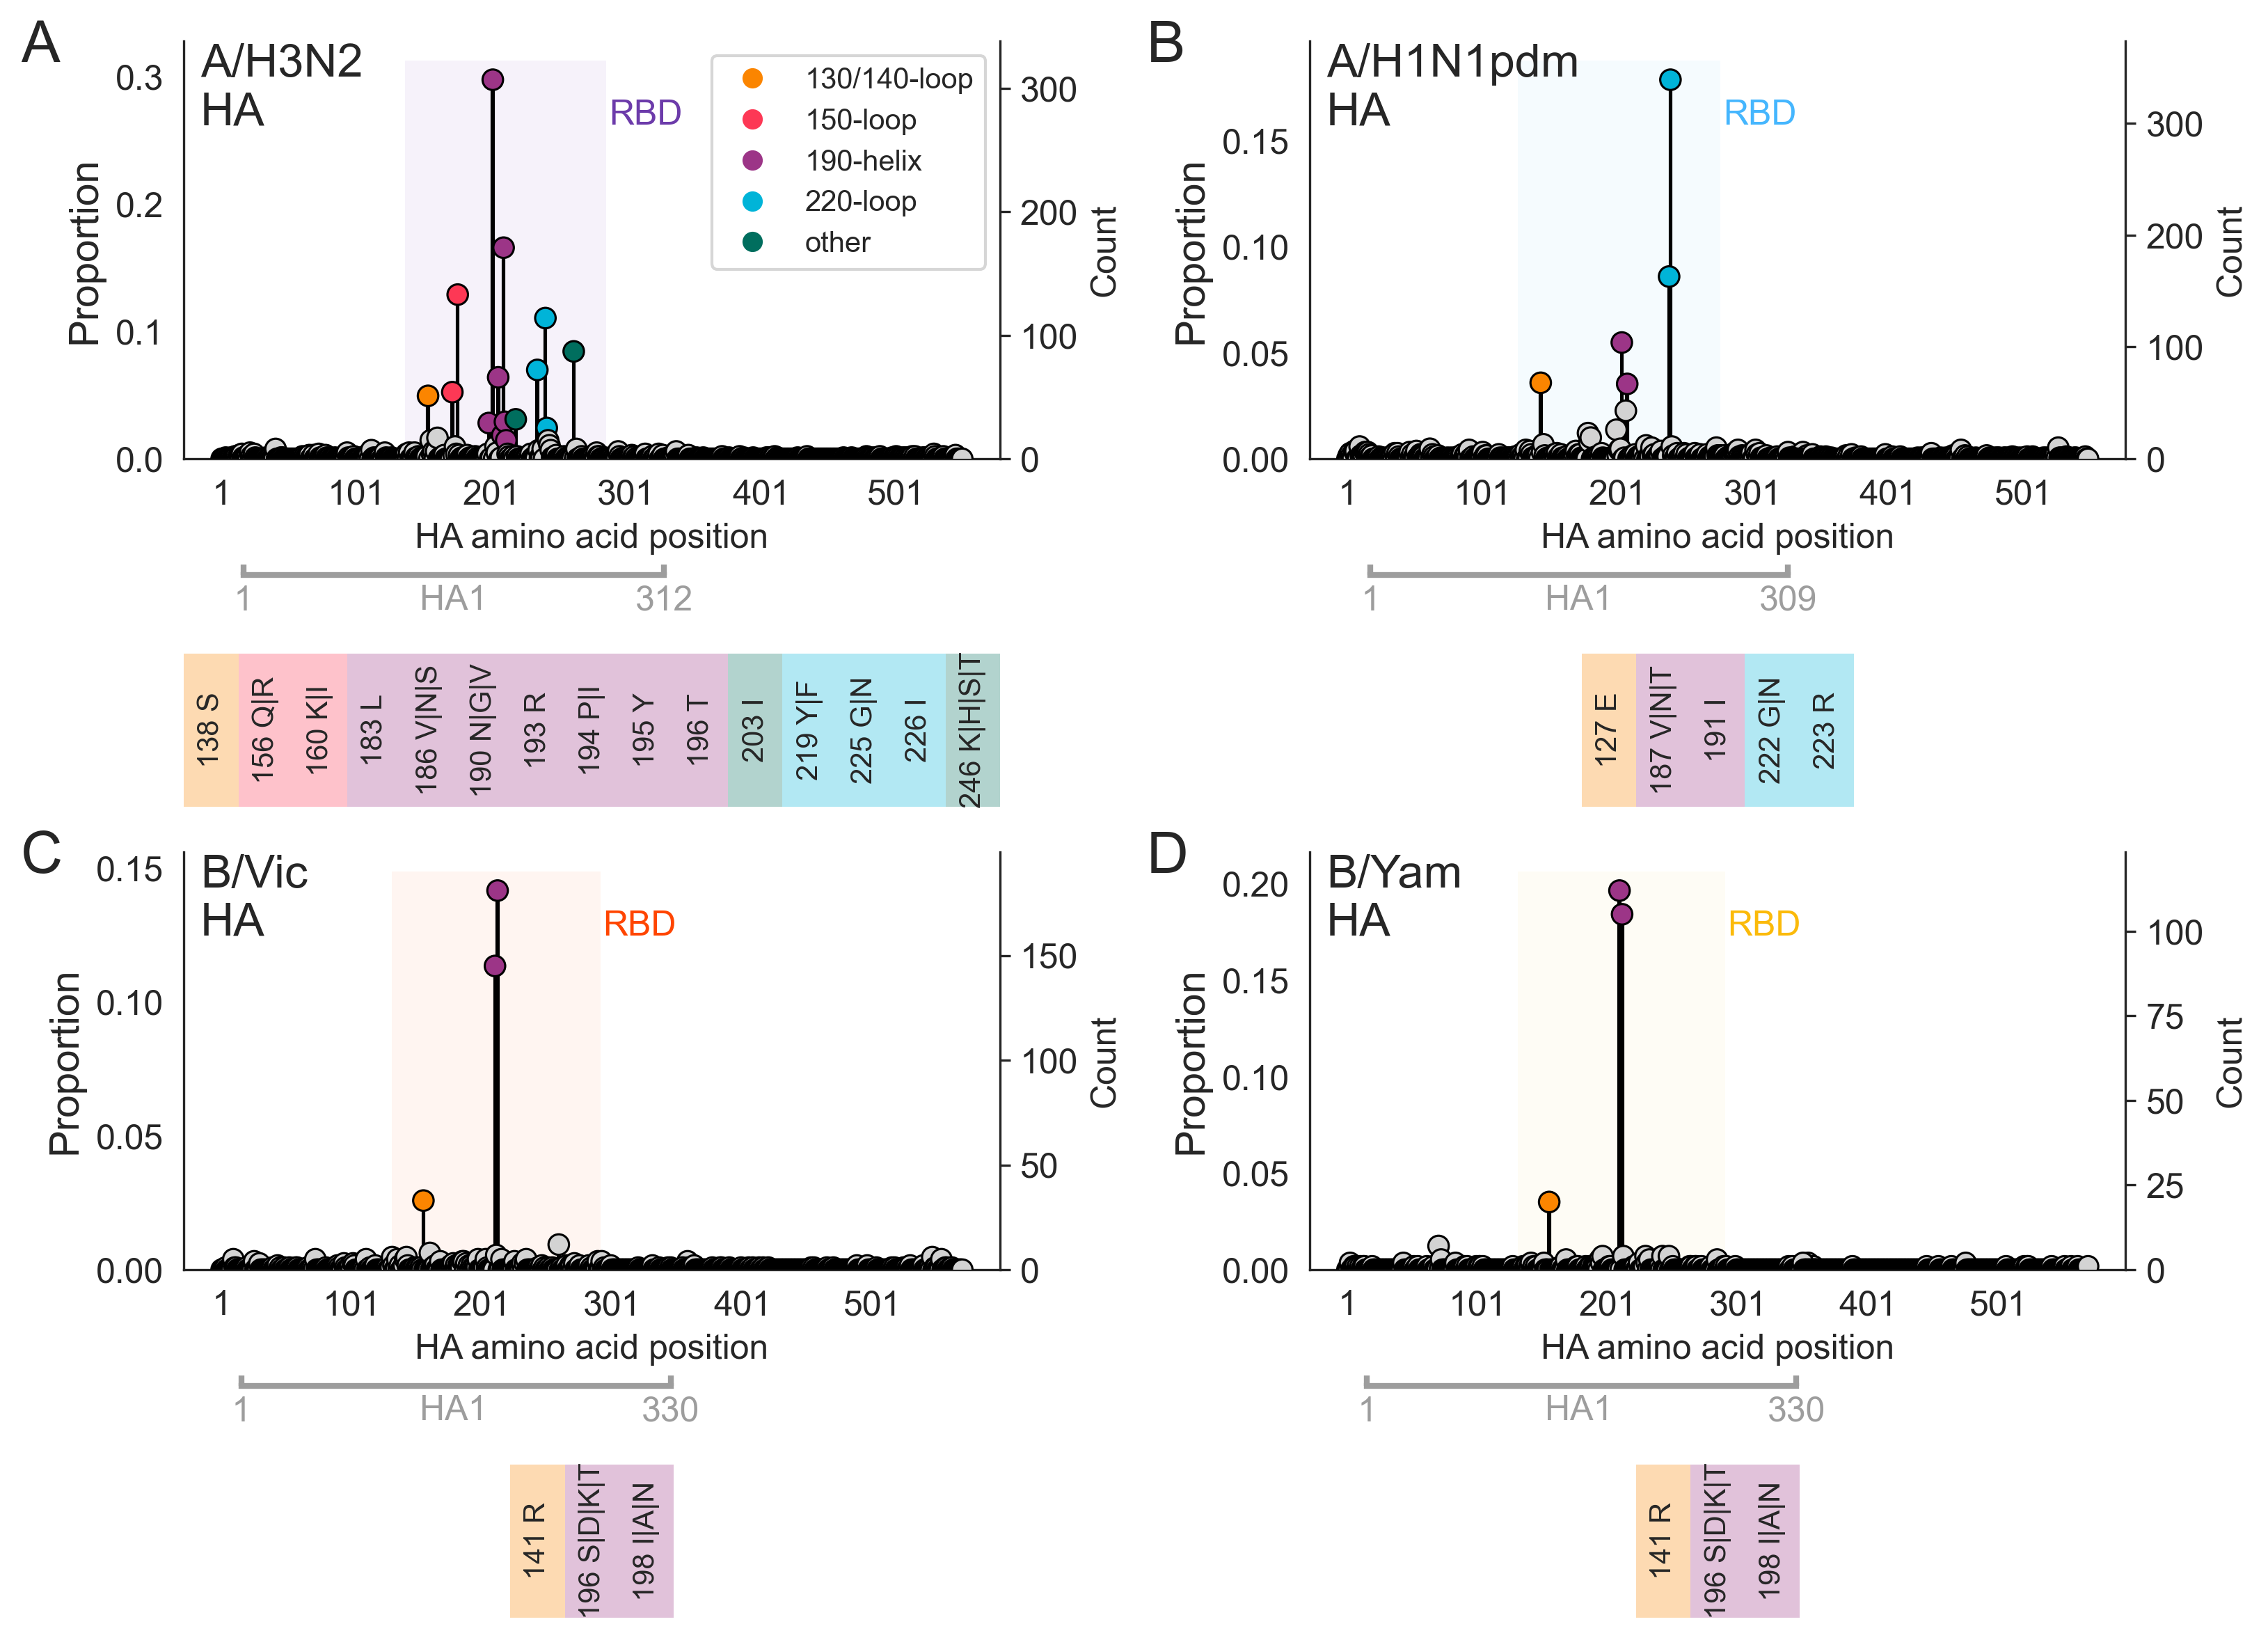

In [194]:
plot_fig3(filename= 'Figure3/Figure3.png')